# SD-TSIA 211 - TP 2 Report - MARCHETTI Pierre

## Digit recognition

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

5
Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2.3204675

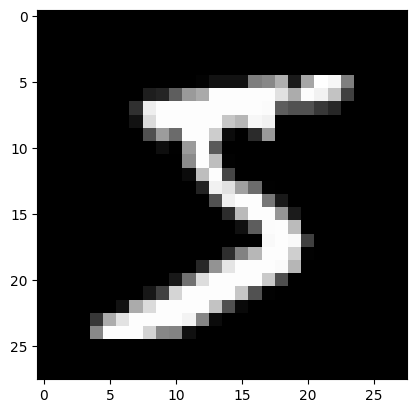

In [16]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1, 784).astype(float) / 255
y_train = train_data[1]
x_test = test_data[0].reshape(-1, 784).astype(float) / 255
y_test = test_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]

# what we would like to get
y_train[0:100]

# Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape:
    # Run the forward pass of the layer.
    # The operations that the layer applies
    # to its inputs are going to be recorded
    # on the GradientTape.
    logits = model(x_train_batch)  # Logits for this minibatch

    # Compute the loss value for this minibatch.
    loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

# Updating weights


def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)


# Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()

# Model

### Q.1- How many optimization variables are we going to train using this model?

We are going to use 26506 optimization variables to train this model.

Indeed,  as we can see with each layer, we have : $785*32 + 33*32 + 33*10 = 26506$ variables.

# Stochastic gradient descent

Epoch 1/4
Step 0/1875 - Loss: 2.3699841499328613
Step 100/1875 - Loss: 2.0352604389190674
Step 200/1875 - Loss: 1.5606474876403809
Step 300/1875 - Loss: 1.11582350730896
Step 400/1875 - Loss: 0.995664119720459
Step 500/1875 - Loss: 0.9628754258155823
Step 600/1875 - Loss: 0.6839108467102051
Step 700/1875 - Loss: 0.5059000849723816
Step 800/1875 - Loss: 0.44083458185195923
Step 900/1875 - Loss: 0.3432714343070984
Step 1000/1875 - Loss: 0.44288843870162964
Step 1100/1875 - Loss: 0.4220098853111267
Step 1200/1875 - Loss: 0.37700706720352173
Step 1300/1875 - Loss: 0.47454240918159485
Step 1400/1875 - Loss: 0.4402204155921936
Step 1500/1875 - Loss: 0.2656039595603943
Step 1600/1875 - Loss: 0.31598472595214844
Step 1700/1875 - Loss: 0.24045220017433167
Step 1800/1875 - Loss: 0.3165321350097656
Epoch 2/4
Step 0/1875 - Loss: 0.42047736048698425
Step 100/1875 - Loss: 0.4198952317237854
Step 200/1875 - Loss: 0.3368965983390808
Step 300/1875 - Loss: 0.22948585450649261
Step 400/1875 - Loss: 0.263

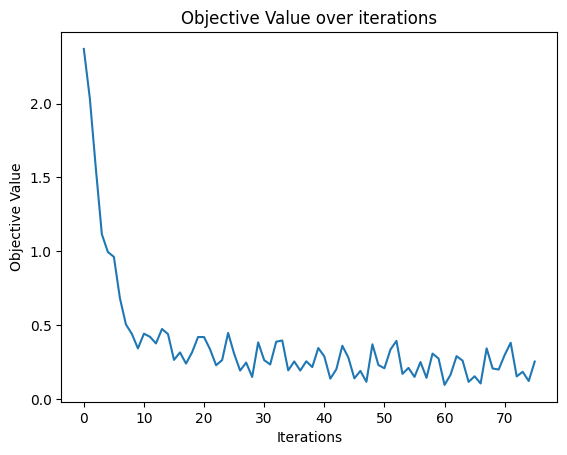

In [8]:
## Re-use the same code as before ##

train_data, _ = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1, 784).astype(float) / 255
y_train = train_data[1]

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

# Loss function
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = keras.optimizers.SGD(learning_rate=0.01)

epochs = 4
batch_size = 32
objective_values = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step in range(len(x_train) // batch_size):
        batch_images = x_train[step*batch_size: (step+1)*batch_size]
        batch_labels = y_train[step*batch_size: (step+1)*batch_size]

        with tf.GradientTape() as tape:
            logits = model(batch_images)
            loss_value = loss(batch_labels, logits)

        gradients = tape.gradient(loss_value, model.trainable_variables)

        # Update weights
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if step % 100 == 0:
            objective_values.append(loss_value.numpy())
            print(
                f"Step {step}/{len(x_train)//batch_size} - Loss: {loss_value}")

plt.plot(range(len(objective_values)), objective_values)
plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.title('Objective Value over iterations')
plt.show()

We can do it for more epoch but it will be longer to compute.

# Empirical risk minimization

In [9]:
(train_images, train_labels), _ = tf.keras.datasets.mnist.load_data()

# Preprocess
train_images = train_images.reshape(-1, 784).astype('float32') / 255
train_labels = train_labels.astype('int64')

# Model
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

# Loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

epochs = 10
batch_size = 32

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step in range(len(train_images) // batch_size):
        batch_indices = np.random.choice(
            len(train_images), size=batch_size, replace=False)
        batch_images = train_images[batch_indices]
        batch_labels = train_labels[batch_indices]

        with tf.GradientTape() as tape:
            logits = model(batch_images)
            loss_value = loss_fn(batch_labels, logits)

        gradients = tape.gradient(loss_value, model.trainable_variables)

        # Update weights
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if step % 100 == 0:
            print(
                f"Step {step}/{len(train_images)//batch_size} - Loss: {loss_value}")

Epoch 1/10
Step 0/1875 - Loss: 2.349649667739868
Step 100/1875 - Loss: 2.0166120529174805
Step 200/1875 - Loss: 1.4251234531402588
Step 300/1875 - Loss: 1.0934208631515503
Step 400/1875 - Loss: 1.1547260284423828
Step 500/1875 - Loss: 0.769197940826416
Step 600/1875 - Loss: 0.5838935375213623
Step 700/1875 - Loss: 0.4931645095348358
Step 800/1875 - Loss: 0.515228271484375
Step 900/1875 - Loss: 0.41570907831192017
Step 1000/1875 - Loss: 0.4795066714286804
Step 1100/1875 - Loss: 0.6078906059265137
Step 1200/1875 - Loss: 0.4686901867389679
Step 1300/1875 - Loss: 0.4285503029823303
Step 1400/1875 - Loss: 0.35577866435050964
Step 1500/1875 - Loss: 0.5266625881195068
Step 1600/1875 - Loss: 1.0468268394470215
Step 1700/1875 - Loss: 0.22026807069778442
Step 1800/1875 - Loss: 0.2401917576789856
Epoch 2/10
Step 0/1875 - Loss: 0.3117632269859314
Step 100/1875 - Loss: 0.3148643672466278
Step 200/1875 - Loss: 0.5301034450531006
Step 300/1875 - Loss: 0.2998291552066803
Step 400/1875 - Loss: 0.357771

### Q.2- What is the advantage of such a scheme ?

Using batch gradient descent we are selecting several samples at each iteration and average their gradient. By doing this, we gain in efficiency and stability (reduce the variance in the gradient estimate). The convergence of the training loss is also faster. 

### Q.3- Add the option of the batch size to your algorithm.

See code provided.

# Evaluation of the model

### Q.1- Evaluate the accuracy of the model on the training set and on the test set.

Training and test accuracy are print after training. 

Values represent percentage of correctly classified samples in the respective datasets.

In [15]:
(train_images, train_labels), (test_images,
                               test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess
train_images = train_images.reshape(-1, 784).astype('float32') / 255
test_images = test_images.reshape(-1, 784).astype('float32') / 255

model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(784,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Compilation
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32, verbose=1)

# Evaluation on training set
train_loss, train_accuracy = model.evaluate(
    train_images, train_labels, verbose=0)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Evaluation on test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3472 - accuracy: 0.8967
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1730 - accuracy: 0.9486
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1361 - accuracy: 0.9589
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1141 - accuracy: 0.9658
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0989 - accuracy: 0.9696
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0880 - accuracy: 0.9724
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0795 - accuracy: 0.9755
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0720 - accuracy: 0.9770
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0670 - accuracy: 0.9787
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.060

We obtain a great accuracy. 